# 🔧 Parameter-Efficient Fine-Tuning (PEFT)

### Adapters and Prefix Tuning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:

def create_text_dataset():
    """Create a text dataset with variable-length sequences"""
    vocab = {
        '<pad>': 0, '<sos>': 1, '<eos>': 2,
        'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
        'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
        'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
        'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25,
        'beautiful': 26, 'garden': 27, 'flowers': 28, 'blooming': 29, 'spring': 30
    }

    # Variable length sentences
    sentences = [
        "the cat sat",                                    # Short
        "the dog ran fast",                              # Medium
        "the bird flew high over the tree",              # Medium-long
        "the quick brown fox jumps over the lazy dog",   # Long
        "the beautiful garden has flowers blooming",     # Medium
        "cat",                                           # Very short
        "the big dog ran fast over the small house near the water",  # Very long
        "bird flew",                                     # Short
        "the spring brings beautiful flowers to the garden",  # Long
        "fox jumps"                                      # Short
    ]

    # Create variable-length tokenized sequences
    tokenized_sequences = []
    for sentence in sentences:
        tokens = [vocab['<sos>']]
        tokens.extend([vocab.get(word, 0) for word in sentence.split()])
        tokens.append(vocab['<eos>'])
        tokenized_sequences.append(torch.tensor(tokens))

    return tokenized_sequences, vocab

In [3]:
# Bottleneck Adapters
class BottleneckAdapter(nn.Module):
    def __init__(self, d_model, bottleneck_size=64, dropout=0.1):
        super().__init__()
        self.down_proj = nn.Linear(d_model, bottleneck_size)
        self.up_proj = nn.Linear(bottleneck_size, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.down_proj(x)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.up_proj(x)
        return x + residual

# Prefix Tuning
class PrefixTuning(nn.Module):
    def __init__(self, num_layers, num_heads, head_dim, prefix_length=20):
        super().__init__()
        self.prefix_length = prefix_length
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.head_dim = head_dim

        # Learnable prefix parameters
        self.prefix_keys = nn.Parameter(
            torch.randn(num_layers, prefix_length, num_heads, head_dim)
        )
        self.prefix_values = nn.Parameter(
            torch.randn(num_layers, prefix_length, num_heads, head_dim)
        )

    def get_prefix_states(self, batch_size, layer_idx):
        prefix_keys = self.prefix_keys[layer_idx].unsqueeze(0).expand(batch_size, -1, -1, -1)
        prefix_values = self.prefix_values[layer_idx].unsqueeze(0).expand(batch_size, -1, -1, -1)
        return prefix_keys, prefix_values

In [4]:
def test_adapters_and_prefix_tuning():
    torch.manual_seed(0)

    # Create a toy input tensor [batch, seq_len, d_model]
    batch_size, seq_len, d_model = 4, 10, 128
    x = torch.randn(batch_size, seq_len, d_model)

    # Test BottleneckAdapter
    bottleneck_size = 32
    adapter = BottleneckAdapter(d_model=d_model, bottleneck_size=bottleneck_size, dropout=0.0)
    out_adapter = adapter(x)
    assert out_adapter.shape == x.shape, "Adapter output shape must match input"

    # Compute norms
    input_norm = x.norm(dim=-1).mean().item()
    output_norm = out_adapter.norm(dim=-1).mean().item()
    print(f"Adapter Input Norm:  {input_norm:.4f}")
    print(f"Adapter Output Norm: {output_norm:.4f}")

    # Visualization: Residual vs Adapter Contribution Norm
    diff = (out_adapter - x).norm(dim=-1).mean().item()
    plt.figure(figsize=(4,4))
    plt.bar(['Residual','Adapter Delta'], [input_norm, diff], color=['blue','orange'])
    plt.title('BottleneckAdapter Contribution')
    plt.ylabel('Mean ||·||₂')
    for i, v in enumerate([input_norm, diff]):
        plt.text(i, v + 0.02 * max(input_norm, diff), f"{v:.2f}", ha='center')
    plt.tight_layout()
    plt.show()

    # Test PrefixTuning
    num_layers, num_heads, head_dim, prefix_length = 3, 8, 16, 5
    prefix = PrefixTuning(num_layers, num_heads, head_dim, prefix_length=prefix_length)

    # For each layer, get prefix states and check shapes
    key_norms, value_norms = [], []
    for layer_idx in range(num_layers):
        pk, pv = prefix.get_prefix_states(batch_size, layer_idx)
        assert pk.shape == (batch_size, prefix_length, num_heads, head_dim)
        assert pv.shape == pk.shape
        key_norms.append(pk.norm().item())
        value_norms.append(pv.norm().item())

    print(f"Prefix key norms per layer:   {[round(n,2) for n in key_norms]}")
    print(f"Prefix value norms per layer: {[round(n,2) for n in value_norms]}")

    # Visualization: Prefix Norms Across Layers
    layers = list(range(num_layers))
    plt.figure(figsize=(6,4))
    plt.plot(layers, key_norms, 'o-', label='Key Norms')
    plt.plot(layers, value_norms, 's--', label='Value Norms')
    plt.title('Prefix Tuning Parameter Norms')
    plt.xlabel('Layer Index')
    plt.ylabel('Frobenius Norm')
    plt.xticks(layers)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Adapter Input Norm:  11.2203
Adapter Output Norm: 11.4857


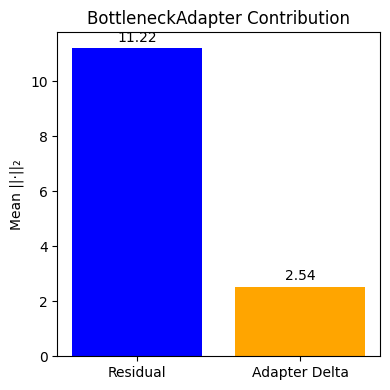

Prefix key norms per layer:   [52.17, 50.1, 49.06]
Prefix value norms per layer: [50.7, 52.38, 48.56]


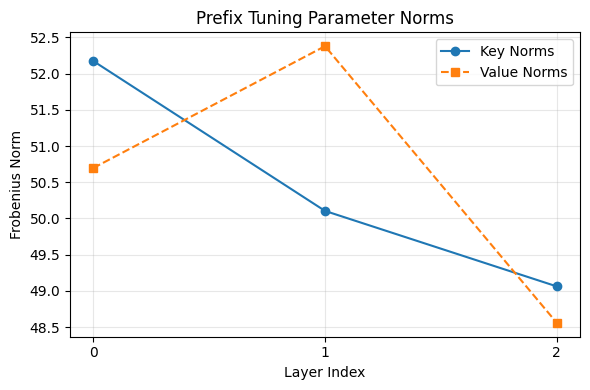

In [5]:
test_adapters_and_prefix_tuning()

### LoRA (Low-Rank Adaptation)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math


In [7]:
def create_padded_text_dataset():
  """Create a text dataset with variable-length sequences"""
  vocab = {
      '<pad>': 0, '<sos>': 1, '<eos>': 2,
      'the': 3, 'cat': 4, 'sat': 5, 'on': 6, 'mat': 7,
      'dog': 8, 'ran': 9, 'fast': 10, 'bird': 11, 'flew': 12, 'high': 13,
      'quick': 14, 'brown': 15, 'fox': 16, 'jumps': 17, 'over': 18, 'lazy': 19,
      'big': 20, 'small': 21, 'house': 22, 'tree': 23, 'water': 24, 'fire': 25,
      'beautiful': 26, 'garden': 27, 'flowers': 28, 'blooming': 29, 'spring': 30
  }

  # Variable length sentences
  sentences = [
      "the cat sat",                                    # Short
      "the dog ran fast",                              # Medium
      "the bird flew high over the tree",              # Medium-long
      "the quick brown fox jumps over the lazy dog",   # Long
      "the beautiful garden has flowers blooming",     # Medium
      "cat",                                           # Very short
      "the big dog ran fast over the small house near the water",  # Very long
      "bird flew",                                     # Short
      "the spring brings beautiful flowers to the garden",  # Long
      "fox jumps"                                      # Short
  ]

  # Create variable-length tokenized sequences
  tokenized = []
  for sentence in sentences:
      tokens = [vocab['<sos>']]
      tokens.extend([vocab.get(word, 0) for word in sentence.split()])
      tokens.append(vocab['<eos>'])
      tokenized.append(tokens)
  # Pad to same length
  max_len = max(len(seq) for seq in tokenized)
  padded = []
  for seq in tokenized:
      padded.append(torch.tensor(seq + [0] * (max_len - len(seq))))

  return torch.stack(padded), vocab

In [8]:
# Gradient Checkpointing
from torch.utils.checkpoint import checkpoint, checkpoint_sequential

# Method 1: Function-based checkpointing
def checkpoint_wrapper(func):
    def wrapper(*args, **kwargs):
        return checkpoint(func, *args, **kwargs)
    return wrapper

# Method 2: Module-based checkpointing
class CheckpointedTransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super().__init__()
        self.attn = nn.MultiheadAttention(d_model, num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Linear(d_ff, d_model)
        )
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, mask=None):
        # Use checkpointing to save memory
        x = x + checkpoint(self._attention_block, self.ln1(x), mask)
        x = x + checkpoint(self.ff, self.ln2(x))
        return x

    def _attention_block(self, x, mask):
        return self.attn(x, x, x, attn_mask=mask)[0]

In [9]:
# Simple Transformer for testing
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len=512, use_checkpointing=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        if use_checkpointing:
            layers = [CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)]
            self.transformer = CheckpointedTransformerStack(layers, segments=2)
        else:
            self.transformer = nn.ModuleList([
                CheckpointedTransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
            ])

        self.ln_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size)
        self.use_checkpointing = use_checkpointing

    def forward(self, x):
        B, T = x.shape
        x = self.embedding(x) + self.pos_embedding[:, :T, :]

        if self.use_checkpointing:
            x = self.transformer(x)
        else:
            for layer in self.transformer:
                x = layer(x)

        x = self.ln_f(x)
        return self.lm_head(x)

In [10]:

# LoRA classes from user code
class LoRALinear(nn.Module):
    def __init__(self, in_features, out_features, rank=8, alpha=16, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.linear.weight.requires_grad = False
        self.lora_A = nn.Linear(in_features, rank, bias=False)
        self.lora_B = nn.Linear(rank, out_features, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.scaling = alpha / rank
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x):
        orig = self.linear(x)
        delta = self.lora_B(self.lora_A(self.dropout(x)))
        return orig + delta * self.scaling

def apply_lora_to_model(model, rank=8, alpha=16, target_modules=['q_proj', 'v_proj']):
    for name, module in model.named_modules():
        if any(t in name for t in target_modules) and isinstance(module, nn.Linear):
            parent_name = '.'.join(name.split('.')[:-1])
            child_name = name.split('.')[-1]
            parent = model.get_submodule(parent_name)
            lora = LoRALinear(module.in_features, module.out_features, rank, alpha)
            lora.linear.weight.data.copy_(module.weight.data)
            setattr(parent, child_name, lora)
    return model

class AdaLoRALinear(nn.Module):
    def __init__(self, in_features, out_features, initial_rank=8, alpha=16, dropout=0.1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.linear.weight.requires_grad = False
        self.initial_rank = initial_rank
        self.alpha = alpha
        self.lora_A = nn.Parameter(torch.randn(initial_rank, in_features))
        self.lora_B = nn.Parameter(torch.randn(out_features, initial_rank))
        self.importance_scores = nn.Parameter(torch.ones(initial_rank))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        mask = torch.sigmoid(self.importance_scores)  # [rank]
        A_masked = self.lora_A * mask.unsqueeze(1)
        B_masked = self.lora_B * mask.unsqueeze(0)
        orig = self.linear(x)
        delta = F.linear(F.linear(self.dropout(x), A_masked), B_masked)
        return orig + delta * (self.alpha / self.initial_rank)




In [11]:
def test_lora_and_adalora():
    torch.manual_seed(0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create toy input
    data, vocab = create_padded_text_dataset()
    batch, seq_len = data.shape
    d_model = 64
    x = torch.randn(batch, seq_len, d_model, device=device)

    # Test LoRALinear standalone
    lora_layer = LoRALinear(d_model, d_model, rank=4, alpha=8).to(device)
    out = lora_layer(x)
    assert out.shape == x.shape

    # Measure LoRA contribution norm
    with torch.no_grad():
        orig = lora_layer.linear(x)
        delta = out - orig
        contrib_norm = delta.norm(dim=-1).mean().item()
    print(f"LoRA contribution norm: {contrib_norm:.4f}")

    # Visualization: histogram of delta values
    plt.figure(figsize=(4,3))
    plt.hist(delta.cpu().flatten().numpy(), bins=50, color='orange', alpha=0.7)
    plt.title('LoRA Delta Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Apply LoRA to transformer model
    model = SimpleTransformer(len(vocab), d_model, num_heads=4, d_ff=128, num_layers=2, max_seq_len=seq_len).to(device)
    # pretend q_proj and v_proj exist in model; for demo apply to all nn.Linear
    model = apply_lora_to_model(model, rank=4, alpha=8, target_modules=['linear'])
    input_ids = data.to(device)          # [batch, seq_len]
    out_model = model(input_ids)
    print(f"Transformer output shape after LoRA: {out_model.shape}")

    # Test AdaLoRA
    adalora_layer = AdaLoRALinear(d_model, d_model, initial_rank=6, alpha=12).to(device)
    out_adalora = adalora_layer(x)
    assert out_adalora.shape == x.shape

    # Track importance scores evolution
    optimizer = torch.optim.Adam([adalora_layer.importance_scores], lr=0.1)
    scores_history = []
    for step in range(20):
        optimizer.zero_grad()
        loss = (adalora_layer(x) - x).pow(2).mean()
        loss.backward()
        optimizer.step()
        scores = torch.sigmoid(adalora_layer.importance_scores).detach().cpu().numpy()
        scores_history.append(scores)
    scores_history = torch.tensor(scores_history)

    # Visualization: importance scores over steps
    plt.figure(figsize=(6,4))
    for i in range(scores_history.size(1)):
        plt.plot(scores_history[:,i], label=f'rank{i}')
    plt.title('AdaLoRA Importance Scores Over Training')
    plt.xlabel('Step')
    plt.ylabel('Sigmoid Importance')
    plt.legend(bbox_to_anchor=(1,1), fontsize=8)
    plt.tight_layout()
    plt.show()

    print("LoRA and AdaLoRA tests completed successfully.")



LoRA contribution norm: 0.0000


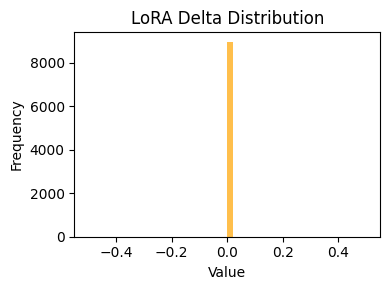

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Transformer output shape after LoRA: torch.Size([10, 14, 31])


/tmp/ipython-input-56359360.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  scores_history = torch.tensor(scores_history)


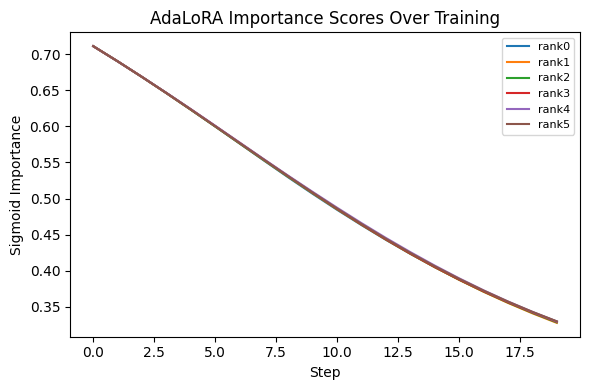

LoRA and AdaLoRA tests completed successfully.


In [12]:
test_lora_and_adalora()